# Wordcount using Kafka

![](https://camo.githubusercontent.com/56166d361c3975dee750ecce16d605bbbf66516b/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f352f35332f4170616368655f6b61666b615f776f7264747970652e737667)

In [16]:
from confluent_kafka import SerializingProducer, DeserializingConsumer
from confluent_kafka.serialization import StringSerializer, StringDeserializer
from confluent_kafka.admin import AdminClient, NewTopic
from uuid import uuid4
import sys, lorem, random

brokers = "kafka1:9092,kafka2:9093"
topics = ["sentences1", "words", "lengths"]

In [17]:
new_topics = [NewTopic(topic, num_partitions=2, replication_factor=1) for topic in topics]

In [18]:
a = AdminClient({'bootstrap.servers': brokers})
a.create_topics(new_topics)

{'sentences1': <Future at 0x7fc0d451e9a0 state=running>,
 'words': <Future at 0x7fc0d425fac0 state=running>,
 'lengths': <Future at 0x7fc0d425fa00 state=running>}

## Producing Sentences

Non amet porro labore neque.
Amet adipisci dolore amet aliquam amet consectetur.
Neque ut neque porro non.
Quiquia dolore magnam eius.
Dolorem quiquia etincidunt magnam non.
Modi quiquia neque adipisci.
Ipsum modi ut neque.
Velit est velit est neque quiquia.
Neque dolorem velit amet quisquam quisquam.
Tempora etincidunt non quiquia magnam dolor dolore.
Sed amet dolore ipsum voluptatem.
Est neque quaerat aliquam eius.

In [19]:
pconf = {
    'bootstrap.servers': brokers,
    'partitioner': 'murmur2_random',
    'key.serializer': StringSerializer('utf_8'),
    'value.serializer': StringSerializer('utf_8')
}

In [20]:
p = SerializingProducer(pconf)

In [21]:
for n in range(1,100):
    try:
        # Produce line (without newline)
        line = lorem.sentence()
        p.produce(topics[0], key=str(uuid4()), value=line)
        p.poll(0)
        p.flush()
        print(line)
    except BufferError:
        sys.stderr.write('%% Local producer queue is full (%d messages awaiting delivery): try again\n' % len(p))

Neque modi est modi neque.
Voluptatem ipsum quiquia voluptatem adipisci.
Etincidunt porro dolorem dolore magnam.
Voluptatem dolor etincidunt sed etincidunt neque porro.
Sed numquam ut dolorem labore eius modi est.
Tempora quiquia sit voluptatem sed.
Dolor adipisci sed adipisci quiquia neque consectetur.
Tempora voluptatem quaerat labore numquam ipsum eius neque.
Adipisci magnam sit modi ut ut ipsum.
Tempora porro porro quaerat sed amet.
Ipsum modi quiquia quaerat numquam etincidunt neque ut.
Aliquam quiquia ut consectetur quiquia modi eius.
Numquam magnam neque non etincidunt.
Sit magnam dolor quaerat non dolore consectetur modi.
Ut porro tempora neque magnam.
Modi est sit quaerat ipsum.
Adipisci magnam quisquam numquam ut dolor voluptatem numquam.
Magnam labore aliquam aliquam.
Ipsum sit tempora modi non etincidunt consectetur.
Quaerat ipsum ut ipsum quiquia magnam non est.
Sit dolorem aliquam consectetur amet magnam.
Modi labore tempora consectetur quisquam non non.
Voluptatem modi a

## Consuming Sentences

In [22]:
string_deserializer = StringDeserializer('utf_8')

In [23]:
consumer_conf = {
    'bootstrap.servers': brokers,
    'key.deserializer': string_deserializer,
    'value.deserializer': string_deserializer,
    'group.id': str(uuid4()),
    'session.timeout.ms': 6000,
    'auto.offset.reset': 'earliest'
}

In [24]:
c = DeserializingConsumer(consumer_conf)
c.subscribe([topics[0]])

In [25]:
try:
    while True:
        # SIGINT can't be handled when polling, limit timeout to 1 second.
        msg = c.poll(1.0)
        if msg is None:
            continue
        if msg.error():
            raise KafkaException(msg.error())
        else:
            print("{} [{}] at offset  {} with key  {}:  {}".format(msg.topic(), msg.partition(), msg.offset(), str(msg.key()), str(msg.value())))
except KeyboardInterrupt:
    sys.stderr.write('%% Aborted by user\n')
finally:
    # Close down consumer to commit final offsets.
    c.close()

sentences1 [1] at offset  0 with key  f4396aaa-30e6-4e8b-b826-ee8a4a4c2d3c:  Voluptatem ipsum quiquia voluptatem adipisci.
sentences1 [1] at offset  1 with key  eb08ecba-8894-4e3c-832a-856ec0306cbb:  Etincidunt porro dolorem dolore magnam.
sentences1 [1] at offset  2 with key  ac8e70b1-64b4-4d1e-8561-c7711d6a349c:  Voluptatem dolor etincidunt sed etincidunt neque porro.
sentences1 [1] at offset  3 with key  158297da-a604-45f2-9b68-4d6963b437b3:  Sed numquam ut dolorem labore eius modi est.
sentences1 [1] at offset  4 with key  fe3ca354-6e71-49d1-b053-f4cda577d7ea:  Tempora quiquia sit voluptatem sed.
sentences1 [1] at offset  5 with key  4f547586-77f9-44a7-8179-8176b7be43f6:  Tempora voluptatem quaerat labore numquam ipsum eius neque.
sentences1 [1] at offset  6 with key  6dafd5c9-3e6b-4166-969e-6c3b4448ea3e:  Adipisci magnam sit modi ut ut ipsum.
sentences1 [1] at offset  7 with key  0be3784e-63d4-4e76-b785-0b7de1be85fd:  Tempora porro porro quaerat sed amet.
sentences1 [1] at offset 

%% Aborted by user


## Consuming Sentences and Producing Words

In [22]:
from confluent_kafka.serialization import IntegerSerializer, IntegerDeserializer

consumer_conf['group.id'] = str(uuid4())
c2 = DeserializingConsumer(consumer_conf)
c2.subscribe([topics[0]])

pconf = {
    'bootstrap.servers': brokers,
    'key.serializer': StringSerializer('utf_8'),
    'value.serializer': IntegerSerializer()
}


p2 = SerializingProducer(pconf)

In [121]:
try:
    while True:
        # SIGINT can't be handled when polling, limit timeout to 1 second.
        msg = c2.poll(1.0)
        if msg is None:
            continue
        if msg.error():
            raise KafkaException(msg.error())
        else:
            for w in msg.value().split(" "):
                print(w)
                p2.produce(topics[1], key=w, value=int(1))
                p2.poll(0)
                p2.flush()
except KeyboardInterrupt:
    sys.stderr.write('%% Aborted by user\n')
finally:
    # Close down consumer to commit final offsets.
    c2.close()

RuntimeError: Consumer closed

## Counting Words

In [24]:
consumer_conf['group.id'] = str(uuid4())
consumer_conf['value.deserializer'] = IntegerDeserializer()

words = {}

In [25]:
c3 = DeserializingConsumer(consumer_conf)
c3.subscribe([topics[1]])

In [26]:
try:
    while True:
        # SIGINT can't be handled when polling, limit timeout to 1 second.
        msg = c3.poll(1.0)
        if msg is None:
            continue
        if msg.error():
            raise KafkaException(msg.error())
        else:
            w = str(msg.key())
            if w in words:
                words[w] = words[w] + msg.value()
            else:
                words[w] = msg.value()
except KeyboardInterrupt:
    sys.stderr.write('%% Aborted by user\n')
finally:
    # Close down consumer to commit final offsets.
    c3.close()

%% Aborted by user


In [28]:
words

{'Dolore': 8,
 'porro': 25,
 'aliquam': 24,
 'neque': 36,
 'adipisci': 36,
 'numquam': 25,
 'neque.': 8,
 'Ut': 14,
 'consectetur': 28,
 'est': 25,
 'numquam.': 6,
 'etincidunt': 16,
 'modi': 32,
 'velit.': 7,
 'Non': 10,
 'velit': 29,
 'voluptatem': 35,
 'tempora': 30,
 'labore.': 8,
 'Dolorem': 10,
 'quiquia': 35,
 'consectetur.': 10,
 'Porro': 6,
 'ipsum': 34,
 'ut': 27,
 'dolor': 25,
 'quiquia.': 8,
 'labore': 21,
 'magnam': 34,
 'quaerat': 33,
 'Quaerat': 13,
 'modi.': 2,
 'Est': 9,
 'sed.': 8,
 'Adipisci': 14,
 'amet': 39,
 'eius.': 12,
 'Amet': 9,
 'dolorem': 21,
 'non': 18,
 'dolorem.': 9,
 'sed': 29,
 'dolore': 39,
 'Eius': 5,
 'eius': 26,
 'quaerat.': 6,
 'Aliquam': 6,
 'sit.': 8,
 'quisquam': 22,
 'amet.': 3,
 'Etincidunt': 5,
 'Quisquam': 1,
 'adipisci.': 5,
 'porro.': 7,
 'Dolor': 4,
 'quisquam.': 9,
 'sit': 27,
 'Neque': 11,
 'aliquam.': 11,
 'Labore': 7,
 'non.': 5,
 'ut.': 6,
 'dolor.': 6,
 'Modi': 8,
 'Quiquia': 14,
 'Magnam': 9,
 'etincidunt.': 14,
 'Consectetur': 5,


In [29]:
import numpy as np
import matplotlib.pyplot as plt

<BarContainer object of 81 artists>

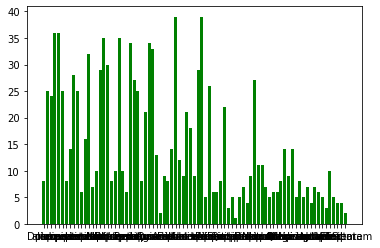

In [30]:
plt.bar(words.keys(), words.values(), color='g')

# Consuming Sentences and producing words lengths

In [43]:
topics[0]

'sentences'

In [126]:
consumer_conf['group.id'] = str(uuid4())
c4 = DeserializingConsumer(consumer_conf)
c4.subscribe([topics[0]])

pconf = {
    'bootstrap.servers': brokers,
    'key.serializer': StringSerializer('utf_8'),
    'value.serializer': IntegerSerializer()
}


p2 = SerializingProducer(pconf)

In [128]:
import time

In [129]:
try:
    while True:
        # SIGINT can't be handled when polling, limit timeout to 1 second.
        msg = c4.poll(1.0)
        if msg is None:
            continue
        if msg.error():
            raise KafkaException(msg.error())
        else:
            for w in msg.value().split(" "):
                print(w)
                p2.produce(topics[2], key=w, value=int(len(w)))
                p2.poll(0)
                p2.flush()
                time.sleep(5)
except KeyboardInterrupt:
    sys.stderr.write('%% Aborted by user\n')
finally:
    # Close down consumer to commit final offsets.
    c4.close()

Dolore
porro
aliquam
neque
adipisci
numquam
neque.
Ut
consectetur


%% Aborted by user


## Calculating the Average

In [151]:
consumer_conf = {
    'bootstrap.servers': brokers,
    'key.deserializer': string_deserializer,
    'value.deserializer': IntegerDeserializer(),
    'group.id': str(uuid4()),
    'session.timeout.ms': 6000,
    'auto.offset.reset': 'earliest'
}

In [152]:
c5 = DeserializingConsumer(consumer_conf)
c5.subscribe([topics[2]])

window = [-1, -1] # opening and closing instance
buffer = []

In [153]:
try:
    while True:
        # SIGINT can't be handled when polling, limit timeout to 1 second.
        msg = c5.poll(1)
        if msg is None:
            continue
        if msg.error():
            raise KafkaException(msg.error())
        else:
            if(window[0]==-1):
                window[0]=msg.timestamp()[1]
                window[1]=msg.timestamp()[1]+4*100
                buffer.append(msg.value())
            elif (msg.timestamp()[1]> window[1]):
                print(buffer)
                print(sum(buffer) / len(buffer))
                old = window[1]
                window[0]= old
                window[1]= old +4*100
                buffer = [msg.value()]
            else:
                buffer.append(msg.value())
except KeyboardInterrupt:
    sys.stderr.write('%% Aborted by user\n')
finally:
    # Close down consumer to commit final offsets.
    c5.close()

[6]
6.0
[5]
5.0
[7]
7.0
[5]
5.0
[8, 7, 6, 2, 11, 3, 8, 8, 2, 10, 4, 6, 3, 5, 5, 10, 4, 7]
6.055555555555555
[7, 7, 7, 7, 4, 12, 5, 5, 4, 2, 5, 8, 3, 10, 6, 4, 5, 8, 3, 8, 6, 7, 3, 5, 6, 12, 3, 4, 7, 10, 6, 4, 6, 6, 7, 7, 11, 5, 3, 6, 10, 7, 8, 4, 8, 5, 10, 5, 4, 5, 4, 7, 7, 8, 7, 8, 8, 5, 7, 4, 4]
6.213114754098361
[3, 8, 3, 3, 7, 7, 6, 7, 3, 10, 5, 3, 5, 4, 2, 7, 4, 4, 7, 4, 8, 7, 7, 4, 7, 4, 2, 7, 6, 8, 8, 4, 5, 6, 3, 5, 4, 5, 5, 3, 10, 3, 10, 8, 10, 5, 3, 5, 5, 8, 6, 8, 5, 7, 8, 8, 4, 3, 4]
5.593220338983051
[5, 9, 8, 8, 10, 2, 6, 5, 2, 5, 7, 5, 4, 6, 8, 7, 8, 7, 7, 7, 4, 12, 6, 5, 3, 9, 8, 5, 5, 12, 6, 10, 3, 7, 6, 7, 4, 7, 8, 3, 7, 3, 5, 6, 8, 5, 7, 3, 4, 8, 6, 5, 3, 10, 7, 5, 5, 7]
6.206896551724138
[11, 5, 5, 5, 5, 6, 7, 5, 4, 2, 7, 8, 4, 3, 5, 4, 4, 3, 6, 4, 6, 6, 4, 3, 4, 7, 6, 7, 7, 5, 8, 5, 3, 5, 6, 7, 3, 2, 6, 8, 7, 3, 8, 7, 4, 4, 7, 5, 4, 6, 7, 2, 5, 5, 6, 11, 11, 7, 11, 11, 2]
5.639344262295082
[7, 4, 7, 10, 8, 7, 7, 7, 3, 11, 3, 4, 4, 6, 3, 4, 5, 8, 11, 7, 5, 5, 5, 7, 11

%% Aborted by user


In [150]:
buffer

[11]